<a href="https://colab.research.google.com/github/chongzicbo/Dive-into-Deep-Learning-tf.keras/blob/master/7.5.%20AdaGrad%E7%AE%97%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##7.5. AdaGrad算法
在之前介绍过的优化算法中，目标函数自变量的每一个元素在相同时间步都使用同一个学习率来自我迭代。举个例子，假设目标函数为 $f $，自变量为一个二维向量 $[x_1, x_2]^\top$ ，该向量中每一个元素在迭代时都使用相同的学习率。例如，在学习率为 $\eta$的梯度下降中，元素 $x_1$ 和 $x_2$ 都使用相同的学习率 $\eta$来自我迭代：
$$
x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \quad
x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}.
$$

在“动量法”一节里我们看到当 $x_1 $和 $x_2$ 的梯度值有较大差别时，需要选择足够小的学习率使得自变量在梯度值较大的维度上不发散。但这样会导致自变量在梯度值较小的维度上迭代过慢。动量法依赖指数加权移动平均使得自变量的更新方向更加一致，从而降低发散的可能。本节我们介绍AdaGrad算法，它根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题 [1]。

###7.5.1. 算法
AdaGrad算法会使用一个小批量随机梯度 $g_t$ 按元素平方的累加变量 $s_t$ 。在时间步0，AdaGrad将 $s_0$ 中每个元素初始化为0。在时间步 $t$ ，首先将小批量随机梯度 $g_t$ 按元素平方后累加到变量 $s_t$ ：
$$
\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,
$$
其中$\odot$ 是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：
$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,
$$
其中 $\eta$ 是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如 $10^{-6}$ 。这里开方、除法和乘法的运算都是按元素运算的。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率。
###7.5.2. 特点
需要强调的是，小批量随机梯度按元素平方的累加变量 $s_t$ 出现在学习率的分母项中。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于 $s_t$ 一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。

下面我们仍然以目标函数 $f(\boldsymbol{x})=0.1x_1^2+2x_2^2$为例观察AdaGrad算法对自变量的迭代轨迹。我们实现AdaGrad算法并使用和上一节实验中相同的学习率0.4。可以看到，自变量的迭代轨迹较平滑。但由于 $s_t$ 的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。


In [0]:
%matplotlib inline
import math
import tensorflow as tf
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.data import Dataset
import time

In [0]:
tf.enable_eager_execution()

In [0]:
def adagrad(x1,x2,s1,s2):
  g1,g2,eps=0.2*x1,4*x2,1e-6
  s1+=g1**2
  s2+=g2**2
  x1-=eta/math.sqrt(s1+eps)*g1
  x2-=eta/math.sqrt(s2+eps)*g2
  return x1,x2,s1,s2

def f_2d(x1,x2):
  return 0.1*x1**2+2*x2**2

In [0]:
def show_trace_2d(f,results):
  plt.plot(*zip(*results),'-o',color='#ff7f0e')
  x1,x2=np.meshgrid(np.arange(-5.5,1.0,0.1),np.arange(-3.0,1.0,0.1))
  plt.contour(x1,x2,f(x1,x2),colors='#1f77b4')
  plt.xlabel('x1')
  plt.ylabel('x2')

def train_2d(trainer):
  x1,x2,s1,s2=-5,-2,0,0 #s1,s2是自变量状态,本章后续几节会使用
  results=[(x1,x2)]
  for i in range(20):
    x1,x2,s1,s2=trainer(x1,x2,s1,s2)
    results.append((x1,x2))
  print('epoch %d,x1 %f,x2 %f'%(i+1,x1,x2))
  return results  

epoch 20,x1 -2.382563,x2 -0.158591


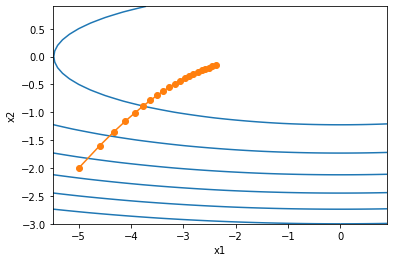

In [0]:
eta=0.4
show_trace_2d(f_2d,train_2d(adagrad))

下面将学习率增大到2。可以看到自变量更为迅速地逼近了最优解。

epoch 20,x1 -0.002295,x2 -0.000000


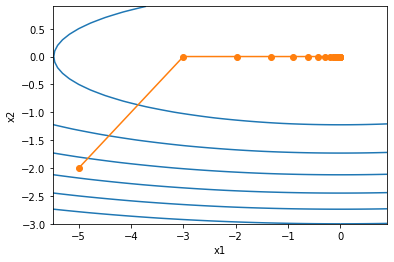

In [0]:
eta=2
show_trace_2d(f_2d,train_2d(adagrad))

###7.5.3. 从零开始实现
同动量法一样，AdaGrad算法需要对每个自变量维护同它一样形状的状态变量。我们根据AdaGrad算法中的公式实现该算法。

In [0]:
from google.colab import drive
drive.mount('/content/drive')

def get_data_ch7():
  data=np.genfromtxt('/content/drive/My Drive/data/d2l-zh-tensoflow/airfoil_self_noise.dat',delimiter='\t')
  data=(data-data.mean(axis=0))/data.std(axis=0)
  return tf.constant(data[:1500,:-1]),tf.constant(data[:1500,-1])

features,labels=get_data_ch7()  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def init_adagrad_states():
  s_w=tf.Variable(tf.zeros((features.shape[1],1),dtype=tf.double))
  s_b=tf.Variable(tf.zeros(1,dtype=tf.double))
  return (s_w,s_b)

In [0]:
def adagrad(params,states,hyperparams,loss,t):
  eps=1e-6
  for p,s in zip(params,states):
    dl_dp=t.gradient(loss,p)
    s.assign_add(tf.square(dl_dp))
    p.assign_sub(hyperparams['lr']*dl_dp/tf.sqrt(s+eps))

In [0]:
def train_ch7(trainer_fn,states,hyperparams,features,labels,batch_size=10,num_epochs=2):
  net,loss=linreg,squared_loss
  w=tf.Variable(tf.random.normal(stddev=0.01,shape=(features.shape[1],1),dtype=tf.double))
  b=tf.Variable(tf.zeros(1,dtype=tf.double))

  def eval_loss():
    return tf.reduce_mean(loss(net(features,w,b),labels)).numpy()

  ls=[eval_loss()]

  data_iter=Dataset.from_tensor_slices((features,labels)).shuffle(buffer_size=1000).batch(batch_size)

  for _ in range(num_epochs):
    start=time.time()
    for batch_i,(X,y) in enumerate(data_iter):
      with tf.GradientTape(persistent=True) as t:
        t.watch([w,b])
        l=tf.reduce_mean(loss(net(X,w,b),y)) #使用平均损失

      trainer_fn([w,b],states,hyperparams,l,t) #迭代模型参数

      if(batch_i+1)*batch_size %100==0:
        ls.append(eval_loss()) #每100个样本记录下当前训练误差
  # 打印结果和作图
  print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
  set_figsize()
  plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
  plt.xlabel('epoch')
  plt.ylabel('loss')  

In [0]:
def use_svg_display():
  #用矢量图显示
  display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
  use_svg_display()
  #设置图的尺寸
  plt.rcParams['figure.figsize']=figsize
  
  
def linreg(X,w,b):
  return tf.matmul(X,w)+b 
  
def squared_loss(y_hat,y):
  return (y_hat-tf.reshape(y,shape=y_hat.shape))**2/2  

loss: 0.242379, 0.453403 sec per epoch


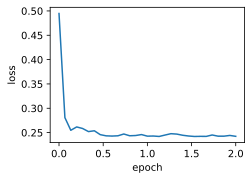

In [0]:
train_ch7(adagrad,init_adagrad_states(),{'lr':0.1},features,labels)

###7.5.4. 简洁实现

In [0]:
def train_keras_ch7(trainer_name,features,labels,batch_size=10,num_epochs=2):
  net=keras.Sequential(keras.layers.Dense(1))
  loss=losses.mean_squared_error
  data_iter=Dataset.from_tensor_slices((features,labels)).shuffle(buffer_size=1000).batch(batch_size)
  net.compile(optimizer=trainer_name,loss=loss,metrics=['mse'])
  history=net.fit_generator(data_iter,epochs=num_epochs)
  loss_ls=history.history['loss']
  set_figsize()
  plt.plot(np.linspace(0,num_epochs,len(loss_ls)),loss_ls)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  return history

Epoch 1/30
150/150 [==============================] - 1s 6ms/step - loss: 1.2273 - mean_squared_error: 1.9098
Epoch 2/30
150/150 [==============================] - 1s 6ms/step - loss: 0.5878 - mean_squared_error: 0.6043
Epoch 3/30
150/150 [==============================] - 1s 6ms/step - loss: 0.5222 - mean_squared_error: 0.5181
Epoch 4/30
150/150 [==============================] - 1s 6ms/step - loss: 0.5024 - mean_squared_error: 0.4966
Epoch 5/30
150/150 [==============================] - 1s 6ms/step - loss: 0.4941 - mean_squared_error: 0.4884
Epoch 6/30
150/150 [==============================] - 1s 6ms/step - loss: 0.4903 - mean_squared_error: 0.4847
Epoch 7/30
150/150 [==============================] - 1s 6ms/step - loss: 0.4884 - mean_squared_error: 0.4829
Epoch 8/30
150/150 [==============================] - 1s 6ms/step - loss: 0.4873 - mean_squared_error: 0.4820
Epoch 9/30
150/150 [==============================] - 1s 6ms/step - loss: 0.4867 - mean_squared_error: 0.4814
Epoch 10/3

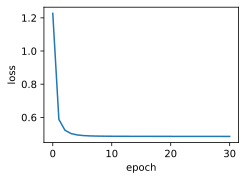

In [0]:
train_keras_ch7(keras.optimizers.Adagrad(learning_rate=0.1),features,labels,num_epochs=30)